# A standard active learning pipeline to efficiently label data for classification
Train accurate classifier models with minimal data labeling (and minimal code) via active learning and AutoML.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cleanlab/examples/blob/master/active_learning_single_annotator/active_learning_single_annotator.ipynb)

This notebook demonstrates a practical approach to efficiently label data for training an accurate image classifier via active learning and AutoML. We consider standard active learning settings with a pool of unlabeled examples, where we label a batch of examples at a time and collect **at most one label** per example. If your data labeling may be noisy (imperfect), then consider our **active_learning_multiannotator** notebook instead, which helps you decide what data to re-label during active learning. The active learning method demonstrated here works for any classification data (text, tabular, audio, etc.) as long as you are able to train a ML model on the labeled subset of the data.

In **Active Learning**, we aim to construct a labeled dataset by collecting the fewest labels that still allow us to train an accurate classifier model. Here we assume data labeling is done in **batches**, and between these data labeling rounds, we retrain our classifier to decide what previously unlabeled examples (i.e. datapoints) to label next round.


This notebook demonstrates how to compute these scores easily for use in sequential active learning, showing how a classification model iteratively improves after labeling more examples for multiple rounds with the following steps:

1. Establish an initially labeled dataset, `df_labeled` to train the model on. This is a small subset of our training data, `df_train`. The rest of the training data is marked as `df_unlabeled`.
2. Train the model on the available labeled data and get predictions for the unlabeled data, `pred_probs_unlabeled`.
3. Compute active learning scores for all unlabeled examples and select which samples to collect labels for.
4. Label the selected samples and add them to current training set.
5. Repeat steps 2-4 to collect as many labels as your budget permits.

The accuracy of the model trained on the resulting dataset will generally match that of the same model trained on a much larger set of randomly selected examples -- i.e. this is the cheapest way to grow a dataset for training an accurate classifier!

## Import dependencies and data

Here we use images from the [Caltech-256](https://data.caltech.edu/records/nyy15-4j048) [1] classification dataset. Any image dataset in the same format can be substituted instead and the same code should work.

In [1]:
import time
import numpy as np
import pandas as pd
from autogluon.multimodal import MultiModalPredictor
from gluoncv.auto.data.dataset import ImageClassificationDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from cleanlab.multiannotator import get_label_quality_scores, get_active_learning_scores
from utils.model_training_autogluon import train

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ActiveLearning/Caltech256/256_ObjectCategories.zip' && unzip -o -q 256_ObjectCategories.zip

File ‘256_ObjectCategories.zip’ already there; not retrieving.



## Construct a small initial labeled dataset
We load our data file into a variable called `dataset`. This is a DataFrame containing labels and file paths for each image (i.e. example) from Caltech-256

We then randomly split the dataset into train and test splits. Test data are just used here to demonstrate the accuracy in our model after each active learning round (you may not have any test data in your applications).

In [3]:
dataset = ImageClassificationDataset.from_folder('./256_ObjectCategories/')
dataset = dataset.replace(257, 256) # no class class in dataset is labeled as 257, we need to reindex

# Split data into train and test
df_train, df_test = train_test_split(dataset, test_size=0.33, random_state=123)

The train data are further split into labeled and unlabeled pools. `df_labeled` represents a small initial labeled dataset which we use to train an initial classifier model (in your application, this would be all the labeled data you have). `df_unlabeled` represents our unlabeled pool of examples we could consider labeling. In this example, we technically know all the labels for these images too -- given they all come from Caltech-256 -- but we demonstrate how active learning would work in your applications by assuming we don't know their labels. In each active learning round, we only reveal the label of specific images the algorithm decides to collect labels for.

In this demonstration, our initial training set (`df_labeled`) has 8 labeled images from each class, which is not enough data to train a good classifier. The goal is to grow this dataset with the fewest number of additional labeled examples that suffice to train an accurate model.

In [4]:
def get_labeled(dataset,  num_labeled_per_class=8):
    """Splits provided dataset into two datasets. With df_labeled containing num_labeled_per_class labeles for 
    each class and df_unlabeled containing the rest of the rows in dataset"""
    
    df_labeled = dataset.groupby("label").sample(n=num_labeled_per_class, random_state=123)
    labeled_index = list(df_labeled.index)
    unlabeled_index = [i for i in range(len(dataset)) if i not in labeled_index]
    df_unlabeled = dataset.iloc[unlabeled_index]
    df_unlabeled = df_unlabeled.reset_index(drop=True)
    df_labeled = df_labeled.reset_index(drop=True)    
    return df_labeled, df_unlabeled

# Split the train data into labeled and unlabeled with 8 labeled per each class
df_labeled, df_unlabeled = get_labeled(df_train, num_labeled_per_class=8)

## Train model on labeled data and get predicted class probabilites for unlabeled data

The first step of the active learning pipeline is to train your model on the available labeled data. Next we ask the trained model for its predictions on the unlabeled data -- specifically the predicted probability of each class for each unlabeled example. The `train()` function below returns our `predictor` fitted to `df_labeled`. To use a different type of model, modify this `train()` function as needed. All you need to run active learning with cleanlab is code to: (1) train your model on the labeled data, (2) get its predicted class probabilities for the unlabeled data, (3) collect labels for the examples with the lowest active learning scores.

In [ ]:
predictor = train(df_labeled, out_folder=None, time_limit=30)
pred_probs_unlabeled = predictor.predict_proba(df_unlabeled)

## Obtain active learning scores for the unlabeled data

Using these predicted class probabilities, you should next compute active learning scores that estimate the informativeness of labeling each datapoint. Since we will collect at most one annotation per example in this pipeline, we only care about scoring the unlabeled data.

These active learning scores represent how confident our model is about an example's true label based on the currently obtained annotations; examples with the lowest scores are those for which additional labels should be collected (i.e. likely the most informative). These scores are estimated via [ActiveLab](https://arxiv.org/abs/2301.11856) [2], an algorithm developed by the Cleanlab team. 

In [ ]:
# compute active learning scores
_, active_learning_scores_unlabeled = get_active_learning_scores(
    df_labeled['label'].to_numpy(), pred_probs_unlabeled=pred_probs_unlabeled
)

In [7]:
# print active learning scores for the first 5 examples in the unlabeld pool:
active_learning_scores_unlabeled[:5]

array([0.00742915, 0.00528911, 0.00507766, 0.00588142, 0.00631748])

## Get index of examples to collect labels for

Subsequently, rank the unlabeled examples by their active learning scores, and obtain the indices of examples with the lowest scores. These are the **unlabeled** examples whose true label our current model is least confident about. You should prioritize these examples for labeling next.

In [8]:
def get_idx_to_label(active_learning_scores_unlabeled, batch_size_to_label):
    """Function to get indices of examples with the lowest active learning score to collect more labels for."""
    
    return np.argsort(active_learning_scores_unlabeled)[:batch_size_to_label]

In [9]:
batch_size_to_label = 100  # you can pick how many examples to collect more labels for at each round, depending on your setup

# get next idx to label based on batch_size_to_label and magnitude of each example's active learning score
next_idx_to_label = get_idx_to_label(active_learning_scores_unlabeled, batch_size_to_label=batch_size_to_label)
next_idx_to_label[:5],active_learning_scores_unlabeled[next_idx_to_label[:5]]

(array([ 7928,  9244,  3141, 11455,  1645]),
 array([0.00469176, 0.00472476, 0.00474545, 0.00476181, 0.00477689]))

## Run 20 rounds of active learning (collecting new labels) to iteratively improve model 

The code below shows a full demonstration of how we can **repeatedly** use the above methods to: select which examples to collect labels for next, add their labels to the current training dataset, and train an improved classifier model.

Here we run 20 rounds of this active learning loop, choosing 100 new unlabeled examples to label in each round. In your applications, you will need to replace the code we used here to reveal the labels of new examples.

[Optional step] After each round, we also report the current model's accuracy on our held-out test dataset (you may not have test data in your applications).

In [10]:
def setup_next_iter_data(df_labeled, df_unlabeled, relabel_idx_unlabeled):
    """Updates inputs after additional labels have been collected in a single active learning round,
    this ensures that the inputs will be well formatted for the next round of active learning."""

    df_labeled = pd.concat([df_labeled,df_unlabeled.iloc[relabel_idx_unlabeled]], ignore_index=True)
    df_unlabeled = df_unlabeled.drop(relabel_idx_unlabeled)
    df_unlabeled = df_unlabeled.reset_index(drop=True)
    df_labeled = df_labeled.reset_index(drop=True)  
    return df_labeled, df_unlabeled

In [11]:
num_rounds = 20
batch_size_to_label = 100

In [ ]:
model_accuracy_arr = np.full(num_rounds, np.nan)

for i in range(num_rounds):
    # train model and obtain predicted class probabilities for the unlabeled data
    print('fitting model')
    predictor = train(df_labeled, out_folder=None, time_limit=60*60)
    
    print('obtaining predicted class probabilities for the unlabeled data')
    pred_probs_unlabeled = predictor.predict_proba(df_unlabeled)
        
    print('computing active learning scores')
    # compute active learning scores
    _, active_learning_scores_unlabeled = get_active_learning_scores(
        df_labeled['label'].to_numpy(), pred_probs_unlabeled=pred_probs_unlabeled
    )
    
    print('getting idx to relabel')
    # get the indices of examples to collect more labels for
    relabel_idx_unlabeled = get_idx_to_label(
        active_learning_scores_unlabeled=active_learning_scores_unlabeled,
        batch_size_to_label=batch_size_to_label,
    )
    
    print('setting up next iter')
    # format the data for the next round of active learning, ie. moving some unlabeled 
    # examples to the labeled pool because we are collecting labels for them
    df_labeled, df_unlabeled = setup_next_iter_data(df_labeled, df_unlabeled, relabel_idx_unlabeled)
    
    # evaluate model accuracy for the current round on held-out test data. This is an optional step 
    # for demonstration purposes, in practical applications you may not have ground truth labels
    print('predicting class labels for test split')
    pred_labels = predictor.predict(data=df_test)
    true_labels_test = np.array(df_test['label'].tolist())
    model_accuracy_arr[i] = np.mean(pred_labels == true_labels_test)
    print('test round: ', i, 'accuracy: ', np.mean(pred_labels == true_labels_test))

## Results

Below, we can see that the model accuracy increases steadily with each additional round of data labeling and model training.

In [24]:
print(f"Initial model test accuracy: {model_accuracy_arr[0]:.3}")
print(f"Final model test accuracy (after 20 rounds of active learning): {model_accuracy_arr[-1]:.3}")

Initial model test accuracy: 0.845
Final model test accuracy (after 20 rounds of active learning): 0.938


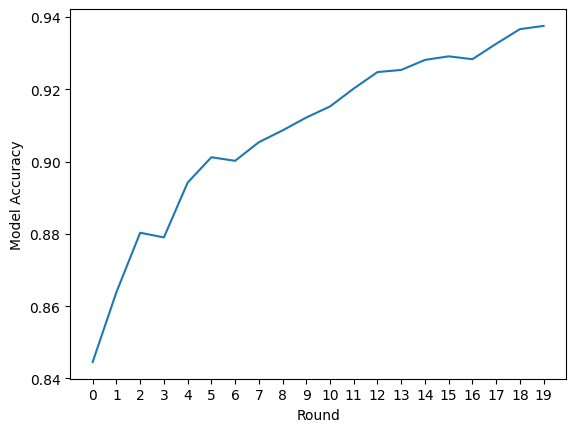

In [23]:
plt.plot(model_accuracy_arr)
plt.xticks(range(num_rounds))
plt.xlabel("Round")
plt.ylabel("Model Accuracy")
plt.show()

### References

[1] Griffin, G., Holub, A., & Perona, P. (2022). Caltech 256 (1.0). https://doi.org/10.22002/D1.20087

[2] Goh, H. W., & Mueller, J. ActiveLab: Active Learning with Re-Labeling by Multiple Annotators. https://arxiv.org/abs/2301.11856